# 📓 Notebook 02: Model Training

## Short description of the notebook

# NOTES
What we have done:

- Load cleaned dataset and transform to X,y

- Split Data

# 📚 Dependencies

In [11]:
# Standard library
import os
import sys
import warnings
import random
import logging
import pickle
from pathlib import Path
import re
import joblib

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Others
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from typing import List, Optional, Union
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple
!pip install sktime
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter
from typing import Generator, Tuple
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.base import clone


# 🌐 General Setup

In [12]:
%%bash
cd /content

REPO=https://github.com/jacopo-raffaeli/portfolio-replica.git
DIR=portfolio-replica

# Clone if needed, else pull latest
if [ ! -d "$DIR" ]; then
  git clone $REPO > /dev/null 2>&1
else
  cd $DIR
  git pull origin main > /dev/null 2>&1
  cd ..
fi

# Enter project root and install dependencies
cd $DIR
pip install -r requirements.txt > /dev/null 2>&1


In [13]:
# Add repo root to sys.path for imports
PROJECT_ROOT = "/content/portfolio-replica"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Set working directory for relative paths
os.chdir(PROJECT_ROOT)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/portfolio-replica


In [30]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

# Seaborn and Matplotlib display options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set reproducible seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define paths
data_raw_path = "data/raw/"
data_interim_path = "data/interim/"
data_processed_path = "data/processed/"

# 🛠 Utilities

## Plots

In [18]:
def plot_series(
    df: pd.DataFrame,
    cols: list,
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot one or more time series."""
    plt.figure()
    ax = df[cols].plot()
    ax.set_title(title or f"Time Series: {', '.join(cols)}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_acf_pacf(
    series: pd.Series,
    lags: int,
    title_prefix: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot ACF and PACF of a series."""
    fig, axes = plt.subplots(2, 1)
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    plot_pacf(series.dropna(), lags=lags, ax=axes[1])
    axes[0].set_title((title_prefix or "") + " ACF")
    axes[1].set_title((title_prefix or "") + " PACF")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_rolling_stats(
    series: pd.Series,
    window: int = 20,
    zscore: bool = False,
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot rolling mean & std or z-score."""
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()

    plt.figure()
    ax = plt.gca()
    if zscore:
        z = (series - rolling_mean) / rolling_std
        z.plot(ax=ax)
        ax.axhline(0, linestyle="--")
        ax.axhline(1, linestyle="--")
        ax.axhline(-1, linestyle="--")
        ax.set_title(title or f"Rolling Z-Score (window={window})")
    else:
        series.plot(ax=ax, alpha=0.5, label="Original")
        rolling_mean.plot(ax=ax, label=f"Mean ({window})")
        rolling_std.plot(ax=ax, label=f"Std ({window})")
        ax.set_title(title or f"Rolling Mean & Std (window={window})")
        ax.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_correlation_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    title: str = None,
    save_path: str = None,
    dpi: int = 300,
    transparent: bool = True
):
    """Plot correlation heatmap."""
    corr = df.corr(method=method)
    plt.figure()
    ax = sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    ax.set_title(title or f"{method.title()} Correlation Matrix")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, transparent=transparent)

def plot_and_save(
    plot_func,
    *args,
    plot_type: str,
    subject: str,
    variant: str = "",
    directory: str = "reports/figures",
    extension: str = "png",
    dpi: int = 300,
    transparent: bool = True,
    show: bool = True,
    **kwargs
):
    """Wrapper to standardize plot saving and naming."""
    Path(directory).mkdir(parents=True, exist_ok=True)
    subject_clean = sanitize_filename(subject)
    variant_clean = sanitize_filename(variant) if variant else ""
    filename_parts = [plot_type, subject_clean]
    if variant_clean:
        filename_parts.append(variant_clean)
    filename = "__".join(filename_parts) + f".{extension}"
    save_path = Path(directory) / filename

    plot_func(*args, save_path=str(save_path), dpi=dpi, transparent=transparent, **kwargs)
    if show:
        plt.show()
    else:
        plt.close()

def sanitize_filename(s: str) -> str:
    """Sanitize strings for filenames (e.g. column names)."""
    return re.sub(r"[^a-zA-Z0-9_]", "_", s.strip().replace(" ", "_"))

## Load & Prepare data

In [38]:
def compute_index_returns(
    df_idx: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> pd.Series:
    """
    Compute weighted composite index returns from raw index price levels.

    Parameters
    ----------
    df_idx : pd.DataFrame
        DataFrame of index price levels (columns are index names).
    index_weights : dict, optional
        Mapping from index column to weight. If None, uses equal weights.

    Returns
    -------
    y : pd.Series
        Composite index returns.
    """
    # Determine which indices to use
    cols = df_idx.columns.tolist()
    if index_weights is None:
        # Equal weights if not provided
        index_weights = {col: 1.0 / len(cols) for col in cols}
    else:
        # Validate provided keys
        missing = set(index_weights) - set(cols)
        if missing:
            raise KeyError(f"Index weights refer to unknown columns: {missing}")

    # Compute simple returns
    ret = df_idx[list(index_weights.keys())].pct_change(fill_method=None).dropna()

    # Apply weights
    weighted = pd.DataFrame({col: ret[col] * weight
                             for col, weight in index_weights.items()},
                            index=ret.index)

    # Sum to get composite
    y = weighted.sum(axis=1)
    y.name = "Target_Index"
    return y

def compute_futures_returns(
    df_fut: pd.DataFrame
) -> pd.DataFrame:
    """
    Compute returns for futures price levels.

    Parameters
    ----------
    df_fut : pd.DataFrame
        DataFrame of futures price levels (columns are futures names).

    Returns
    -------
    X : pd.DataFrame
        Futures returns DataFrame.
    """
    X = df_fut.pct_change(fill_method=None).dropna()
    return X

def align_features_target(
    X: pd.DataFrame,
    y: pd.Series
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Align feature and target on common datetime index.

    Parameters
    ----------
    X : pd.DataFrame
        Feature returns with datetime index.
    y : pd.Series
        Target returns with datetime index.

    Returns
    -------
    X_aligned : pd.DataFrame
    y_aligned : pd.Series
        Subsets of X and y sharing the same index.
    """
    common_idx = X.index.intersection(y.index)
    X_aligned = X.loc[common_idx]
    y_aligned = y.loc[common_idx]
    return X_aligned, y_aligned

def prepare_X_y(
    df_indices: pd.DataFrame,
    df_futures: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    High-level wrapper: compute and align index and futures returns.

    Parameters
    ----------
    df_indices : pd.DataFrame
        Raw index price levels.
    df_futures : pd.DataFrame
        Raw futures price levels.
    index_weights : dict, optional
        Composite index weights. Default: equal weights.

    Returns
    -------
    X, y : aligned returns ready for modeling
    """
    y = compute_index_returns(df_indices, index_weights=index_weights)
    X = compute_futures_returns(df_futures)
    X_aligned, y_aligned = align_features_target(X, y)
    return X_aligned, y_aligned


## Split Data

In [20]:
def generate_backtest_splits(
    y: pd.Series,
    strategy: str = "sliding",
    window_length: int = 52,
    step_length: int = 1
) -> Generator[Tuple[pd.Index, pd.Index], None, None]:
    """
    One-step-ahead backtest splits for replication.

    At each fold:
      - Train on `window_length` points (or all past for expanding)
      - Test on the single point immediately after that window (t+1)

    Parameters
    ----------
    y : pd.Series
        Target series (index only used for length).
    strategy : {'sliding', 'expanding'}
        'sliding'   → fixed-size rolling window of length `window_length`.
        'expanding' → growing window that starts at size `window_length` and then increases.
    window_length : int
        For 'sliding': # samples in each train window.
        For 'expanding': # samples in initial train window.
    step_length : int
        How many periods to move forward between fits.

    Yields
    ------
    train_idx : np.ndarray
        Integer positions for training (length = window_length or growing).
    test_idx : np.ndarray
        Single-element array containing the one-step-ahead index.
    """
    # always one-step ahead
    fh = [1]
    if strategy == "sliding":
        splitter = SlidingWindowSplitter(
            window_length=window_length,
            step_length=step_length,
            fh=fh
        )
    elif strategy == "expanding":
        splitter = ExpandingWindowSplitter(
            initial_window=window_length,
            step_length=step_length,
            fh=fh
        )
    else:
        raise ValueError(f"Unknown strategy '{strategy}'")

    for train_idx, test_idx in splitter.split(y):
        yield train_idx, test_idx


## Simulate Backtest

In [25]:
def compute_step_metrics(y_true: float, y_pred: float) -> dict:
    """Compute per-step metrics."""
    error = y_true - y_pred
    return {
        'error': error,
        'abs_error': abs(error),
    }

def compute_aggregate_metrics(target_series: pd.Series, replica_series: pd.Series) -> dict:
    """Compute aggregate backtest metrics."""
    tracking_error = (target_series - replica_series).std()
    #mse = mean_squared_error(target_series, replica_series)
    #r2 = r2_score(target_series, replica_series)
    var99 = -np.percentile(target_series - replica_series, 1)
    # Annualized Sharpe (weekly data -> *sqrt(52))
    excess = replica_series - target_series
    sharpe = (excess.mean() * 52) / (excess.std() * np.sqrt(52)) if excess.std() > 0 else np.nan
    return {
        #'mse': mse,
        #'r2': r2,
        'tracking_error': tracking_error,
        'var99': var99,
        'sharpe_excess': sharpe
    }

def simulate_backtest(
    X: pd.DataFrame,
    y: pd.Series,
    splitter,
    build_model,
    model_params: dict,
    constraint_funcs: list = None
) -> dict:
    """
    Simulate a one-step-ahead replication backtest with weight unscaling and metrics.

    Returns dict with:
      - weights_history: (n_periods, n_assets)
      - scale_history:   list of scale_ arrays from scaler
      - step_metrics:   list of per-step metric dicts
      - replica_returns, target_returns: pd.Series
      - metrics:        aggregate metrics dict
    """
    weights_history = []
    scale_history = []
    step_metrics = []
    replica_returns = []
    target_returns = []
    dates = []

    for train_idx, test_idx in splitter:
        # Prepare data
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_next = X.iloc[test_idx].values.flatten()
        y_next = y.iloc[test_idx].iloc[0]
        date_next = y.index[test_idx][0]

        # Build and fit model pipeline
        model = build_model(**model_params)
        model.fit(X_train, y_train)

        # Extract scaler and regressor
        scaler = model.named_steps.get('scaler', None)
        reg = model.named_steps['regressor']
        w_scaled = reg.coef_.copy()

        # Unscale weights if scaler present
        if scaler is not None and hasattr(scaler, 'scale_'):
            scale = scaler.scale_.copy()
            w_orig = w_scaled / scale
        else:
            scale = np.ones_like(w_scaled)
            w_orig = w_scaled.copy()

        # Apply constraints
        if constraint_funcs:
            for fn in constraint_funcs:
                w_orig = fn(w_orig, weights_history, replica_returns)

        # Compute returns and metrics
        r_rep = float(np.dot(X_next, w_orig))
        step_m = compute_step_metrics(y_next, r_rep)

        # Record
        weights_history.append(w_orig)
        scale_history.append(scale)
        step_metrics.append(step_m)
        replica_returns.append(r_rep)
        target_returns.append(y_next)
        dates.append(date_next)

    # Assemble time series
    weights_array = np.vstack(weights_history)
    replica_series = pd.Series(replica_returns, index=dates, name='replica_return')
    target_series = pd.Series(target_returns, index=dates, name='target_return')

    # Aggregate metrics
    agg_metrics = compute_aggregate_metrics(target_series, replica_series)

    return {
        'weights_history': weights_array,
        'scale_history': scale_history,
        'step_metrics': step_metrics,
        'replica_returns': replica_series,
        'target_returns': target_series,
        'aggregate_metrics': agg_metrics
    }


# 🧩 Prepare Dataset

In [39]:
# Load dataset & retrieve X, y
indices_filepath = data_processed_path + "indices.parquet"
futures_filepath = data_processed_path + "futures_cleaned_imp_LLL1.parquet"

df_indeces = pd.read_parquet(indices_filepath)
df_futures = pd.read_parquet(futures_filepath)

index_weights = {
    'HFRXGL': 0.50,
    'MXWO':   0.25,
    'MXWD':   0.,
    'LEGATRUU': 0.25
}

X, y = prepare_X_y(df_indeces, df_futures)


In [16]:
#TODO: Visualize the monster index and its relations with the futures

# 🧠 Train Model

Aggregate metrics:
 {'tracking_error': 0.003312512917631093, 'var99': np.float64(0.007847020717852732), 'sharpe_excess': np.float64(-0.014730641994434652)}

First 5 replica vs target returns:
            target_return  replica_return
2010-10-26          0.006           0.003
2010-11-02          0.006           0.005
2010-11-09          0.011           0.013
2010-11-16         -0.025          -0.022
2010-11-23         -0.002           0.004


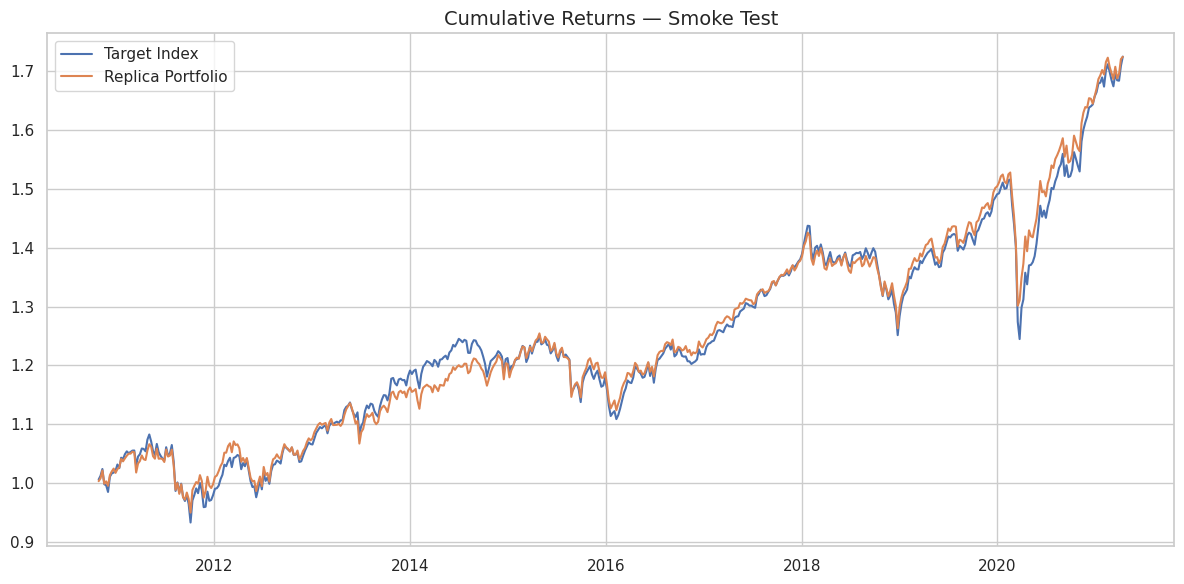

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.pipeline import Pipeline

# Choose a simple build_model factory
def build_model(alpha=0.01, l1_ratio=0.0):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
    ])

# Pick a splitter: sliding window, 52-week lookback, rebalance monthly (step=4)
window, step =156, 1
splits = generate_backtest_splits(y, strategy="sliding", window_length=window, step_length=step)

# Run the backtest simulation
result = simulate_backtest(
    X, y,
    splitter=splits,
    build_model=build_model,
    model_params={"alpha": 0.010, "l1_ratio": 0.0},
    constraint_funcs=None
)

# Inspect the outputs
print("Aggregate metrics:\n", result["aggregate_metrics"])
print("\nFirst 5 replica vs target returns:")
print(pd.concat([result["target_returns"], result["replica_returns"]], axis=1).head())

# Plot cumulative returns to see how the replica tracks
import matplotlib.pyplot as plt
cum_target  = (1 + result["target_returns"]).cumprod()
cum_replica = (1 + result["replica_returns"]).cumprod()

plt.plot(cum_target, label="Target Index")
plt.plot(cum_replica, label="Replica Portfolio")
plt.title("Cumulative Returns — Smoke Test")
plt.legend()
plt.tight_layout()
plt.show()


# PUSH

In [ ]:
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

In [ ]:
from getpass import getpass
import os

# 1. Get your GitHub Personal Access Token securely
token = getpass("Paste your GitHub Personal Access Token: ")
os.environ['GITHUB_TOKEN'] = token

# 2. Set your GitHub repo details
GITHUB_USERNAME = "jacopo-raffaeli"
REPO_NAME = "portfolio-replica"
BRANCH = "main"

# 3. Construct remote URL with token embedded (hidden from output)
remote_url = f"https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# 4. Set git user info (if not done already)
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

# 5. Change remote origin URL to token-embedded one
!git remote set-url origin {remote_url}


Paste your GitHub Personal Access Token: ··········


In [ ]:
# 6. Add and commit changes (customize your commit message)
!git add .
!git commit -m "feat: Add Initial EDA" || echo "No changes to commit."

# 7. Push to GitHub
!git push origin {BRANCH}

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
No changes to commit.
Everything up-to-date


In [ ]:
# Show git status, which files are changed and staged
!git status

# Show last commit files changed (to check if notebook was included)
!git show --name-only --oneline -1

# Show current branch
!git branch

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
f00faf2 (HEAD -> main, origin/main, origin/HEAD) Created using Colab
notebooks/01_Exploratory_Data_Analysis.ipynb
* main
